# Dataframe design

Allow this to be loaded into a dataframe, annotated, and mutated (making bad examples out of good)

In [1]:
# Want to take a file, find all the good instances of it, 
# then make random permutations that are wrong, keeping track of where it's wrong, and updating
# all the indexes as appropriate
from pandas import DataFrame

class CodeAnnotationSet():
    
    # Base columns: 
    #  filename: Name of source file
    #  data: Contents of file
    #  source: ID of file from which this permuted, -1 if raw file
    def __init__(self):
            self.df = DataFrame(columns=["filename", "data", "source"])
            
    def LoadFile(self, filename):
        file = open(filename)
        data = file.read()
        self.df = self.df.append({"filename": filename, 
                                  "data": data,
                                  "source":-1}, ignore_index = True)
        
        



In [2]:
ds = CodeAnnotationSet()
ds.LoadFile("/build/hg/xen.git/xen/arch/x86/mm.c")

In [4]:
ds.LoadFile("/build/hg/xen.git/xen/arch/x86/domain.c")

In [5]:
from IPython.display import display, HTML
import html
from numpy.random import choice, randint
import re

def annotate(s, annotations):
    # Converts to HTML:
    #  - Escapes existing code
    #  - Annotates tuples (index, color) of individual characters with color
    if not isinstance(annotations, list):
        annotations = [annotations]
    offset = 0
    escape_start = 0
    for a in annotations:
        (i, color) = a
        imod = i + offset

        # Escape from last_index up to imod
        e = html.escape(s[escape_start:imod])
        offset += len(e) - (imod - escape_start)
        s = s[:escape_start] + e + s[imod:]
        
        # Insert color around one specific 
        imod = i + offset
        pre = f"<span style=\"background-color:{color}\">"
        post = "</span>"
        s = s[:imod]+pre+s[imod:imod+1]+post+s[imod+1:]
        offset += len(pre) + len(post)
        
        escape_start = offset + i + 1

    # Escape the last bit
    s = s[:escape_start] + html.escape(s[escape_start:])

    return s


class RuleKeywordSpaceBracket:
    reg_good = re.compile('\s(?:if|while|for)( \()', flags=re.M)
    
    #reg_bad  = re.compile('\s(?:if|while|for)([^ ][^(])', flags=re.M)
    reg_bad  = re.compile('\s(?:if|while|for)(\()', flags=re.M)


    def get_annotations(self, data):
        data_iter = self.reg_good.finditer(data)
        good = []
        for match in data_iter:
            good.append(match.start(1) + len(match.group(1))-1)
        data_iter = self.reg_bad.finditer(data)
        bad = []
        for match in data_iter:
            bad.append(match.start(1) + len(match.group(1))-1)
        return (good, bad)
    
    def annotate(self, ds):
        df = ds.df
        if not 'ksb_good' in df.columns:
            # NB this must be 'None' here rather than NaN, so that we can fill it
            # with a tensor.  (Otherwise pandas thinks it should do something fancy with the tensor
            # but can't figure out what.)
            df['ksb_good'] = None
            df['ksb_bad'] = None
        
        for i in df.index:
            (good, bad) = self.get_annotations(df.loc[i, "data"])
            # If we have more "bad" examples than good, this must be the wrong style for this file
            if len(good) < len(bad):
                print(f"{len(good)} good < {len(bad)} bad, skipping file")
                continue
            df.at[i, "ksb_good"] = good
            df.at[i, "ksb_bad"] = bad
    
    def display(self, ds, index):
        df = ds.df
        data = df.loc[index, "data"]
        good = df.loc[index, "ksb_good"]
        bad = df.loc[index, "ksb_bad"]

        annotations = [(i, "lime") for i in good]
        annotations += [(i, "hotpink") for i in bad]
        annotations.sort()
        
        display(HTML("<pre>"+annotate(data, annotations)))
        
    def mutate_string(self, data, orig_good, count):
        to_corrupt = choice(orig_good, count, replace=False)
        
        to_corrupt.sort()
        offset = 0
        for i in to_corrupt:
            imid = i + offset
            # "if (" => "if(", index points to the (
            data = data[:imid-1] + data[imid:]
            offset -= 1
            #print(get_full_line(data, imid))

        return data
    
    def mutate_df(self, ds, index, count):
        df = ds.df
        # Take a number of the 'good' elements from df[index] and make them bad
        filename = df.loc[index, "filename"]
        new_data = df.loc[index, "data"]
        orig_good = df.loc[index, "ksb_good"]
        orig_bad = df.loc[index, "ksb_bad"]

        if not isinstance(orig_good, list):
            print(f"Index {index} not annotated yet, refusing to continue")
            return
            
        new_data = self.mutate_string(new_data, orig_good, count)
        
        (good, bad) = self.get_annotations(new_data)
        
        #print(f"{count}: {len(orig_good)} {len(orig_bad)} => {len(good)} {len(bad)}")
        
        assert len(good) == len(orig_good) - count
        assert len(bad) == len(orig_bad) + count

        ds.df = df.append({"filename":filename,
                            "data":new_data,
                            "source": index,
                            "ksb_good": good,
                            "ksb_bad": bad}, ignore_index=True)
    
    def mutate_batch(self, ds, mutations, indexes=None, min_bad=0.1, max_bad=0.4):
        if indexes is None:
            tf = ds.df['source']==-1
        else:
            tf = ds.df['index']==indexes
        
        sdf = ds.df[tf]
        
        to_corrupt = choice(sdf.index, mutations)
        for index in to_corrupt:
            #print(f"Corrupting index {index}")
            good = sdf.loc[index, "ksb_good"]
            bad  = sdf.loc[index, "ksb_bad"]
            
            if not isinstance(good, list):
                print(f"Index {index} not annotated yet; please call ksb.annotate(ds)")
                return
            tot = len(good) + len(bad)
            mincount = int(tot * min_bad)
            maxcount = int(tot * max_bad)
            mincount = max(mincount - len(bad), 0)
            maxcount = max(maxcount - len(bad), 0)
            
            count = randint(mincount, maxcount)
            
            #print(f"{tot} {len(bad)} {mincount} {maxcount} {count}")
        
            self.mutate_df(ds, index, count)
        
        
ksb = RuleKeywordSpaceBracket()

In [6]:
ksb.annotate(ds)

In [215]:
ds.df

filename  \
0       /build/hg/xen.git/xen/arch/x86/mm.c   
1   /build/hg/xen.git/xen/arch/x86/domain.c   
2   /build/hg/xen.git/xen/arch/x86/domain.c   
3       /build/hg/xen.git/xen/arch/x86/mm.c   
4   /build/hg/xen.git/xen/arch/x86/domain.c   
5   /build/hg/xen.git/xen/arch/x86/domain.c   
6       /build/hg/xen.git/xen/arch/x86/mm.c   
7   /build/hg/xen.git/xen/arch/x86/domain.c   
8   /build/hg/xen.git/xen/arch/x86/domain.c   
9   /build/hg/xen.git/xen/arch/x86/domain.c   
10  /build/hg/xen.git/xen/arch/x86/domain.c   
11  /build/hg/xen.git/xen/arch/x86/domain.c   
12  /build/hg/xen.git/xen/arch/x86/domain.c   
13      /build/hg/xen.git/xen/arch/x86/mm.c   
14  /build/hg/xen.git/xen/arch/x86/domain.c   
15  /build/hg/xen.git/xen/arch/x86/domain.c   
16      /build/hg/xen.git/xen/arch/x86/mm.c   
17  /build/hg/xen.git/xen/arch/x86/domain.c   
18  /build/hg/xen.git/xen/arch/x86/domain.c   
19  /build/hg/xen.git/xen/arch/x86/domain.c   
20      /build/hg/xen.git/xen/arch/x86/mm.c   

                                                 data source  \
0   /*********************************************...     -1   
1   /*********************************************...     -1   
2   /*********************************************...     -1   
3   /*********************************************...      0   
4   /*********************************************...      1   
5   /*********************************************...      1   
6   /*********************************************...      0   
7   /*********************************************...      2   
8   /*********************************************...      1   
9   /*********************************************...      2   
10  /*********************************************...      2   
11  /*********************************************...      1   
12  /*********************************************...      2   
13  /*********************************************...      0   
14  /*********************************************...      2   
15  /*********************************************...      1   
16  /*********************************************...      0   
17  /*********************************************...      1   
18  /*********************************************...      2   
19  /*********************************************...      2   
20  /*********************************************...      0   

                                             ksb_good  \
0   [6723, 6821, 7245, 7697, 8301, 8475, 10745, 10...   
1   [2008, 2473, 3184, 3209, 3346, 3633, 4467, 493...   
2   [2008, 2473, 3184, 3209, 3346, 3633, 4467, 493...   
3   [6820, 7244, 7696, 8300, 8474, 10930, 10990, 1...   
4   [2008, 2473, 3184, 3209, 3346, 4466, 4929, 543...   
5   [2008, 2473, 3184, 3209, 3346, 3633, 4467, 493...   
6   [6723, 7244, 7696, 8300, 8474, 10744, 10931, 1...   
7   [2008, 2473, 3184, 3631, 4465, 4928, 5434, 647...   
8   [2008, 3183, 3208, 3345, 3632, 4928, 5434, 647...   
9   [2008, 3183, 3208, 3345, 3632, 4466, 4929, 543...   
10  [3182, 3207, 3344, 3631, 4465, 4928, 5434, 647...   
11  [2008, 2473, 3184, 3209, 3346, 3633, 4467, 647...   
12  [2008, 2473, 3184, 3209, 3346, 3633, 4467, 493...   
13  [6723, 6821, 7245, 7697, 8301, 10744, 10990, 1...   
14  [2008, 2473, 3184, 3209, 3346, 4466, 5434, 745...   
15  [2008, 2473, 3184, 3209, 3346, 4466, 4929, 543...   
16  [6723, 6821, 7245, 7697, 8474, 10744, 10931, 1...   
17  [2008, 2473, 3184, 3631, 4465, 5433, 6472, 653...   
18  [2008, 3207, 3344, 3631, 4465, 5433, 6472, 653...   
19  [2472, 3207, 4925, 5431, 7384, 7454, 7909, 811...   
20  [6723, 6821, 7245, 7697, 8301, 8475, 10745, 10...   

                                              ksb_bad  \
0                                                  []   
1                                                  []   
2                                                  []   
3   [6722, 10743, 11145, 13086, 13243, 20147, 3078...   
4   [3632, 10020, 10291, 10831, 11928, 13091, 1455.

In [8]:
ksb.mutate_batch(ds, 18)

In [161]:
ksb.display(ds, 5)

# Design the model

In [13]:
import torch.nn as nn
import torch
import numpy as np
import string

class RNN(nn.Module):
    #criterion = nn.NLLLoss()
    
    class token_class:
        # Shared across all instances: Valid letters
        char = string.printable
        special=["UNK", "BOF", "EOF", "PAD"]
        count = len(char) + len(special)
        
        def Special(self, name):
            idx = self.special.index(name)
            assert idx >= 0
            return idx + len(self.char)
        
        # Find letter index from all_letters, e.g. "a" = 0
        def letterToIndex(self, letter):
            idx = self.char.find(letter)
            if idx < 0:
                idx = self.Special("UNK")
            assert idx < self.count
            return idx

        # Turn a string into a tensor with letter indexes
        def stringToArray(self, string):
            return [self.letterToIndex(c) for c in string]
    
    def __init__(self, categories, default_pweight=400.0, pweights=None,
                 embed_dim=-1, hidden_size=32, layers=3, dropout=0.0):
        super(RNN, self).__init__()

        self.tokens = self.token_class()

        # We may want the ability to extend this in the future
        self.categories = categories
        self.ncategories = len(self.categories)
        
        if pweights is None:
            pweights = [default_pweight] * len(self.categories)
        
        assert len(pweights) == len(self.categories)
        
        self.pweights = torch.tensor(pweights)
        
        # If no embedding dimension is specified, use log2 of the number of tokens * 2
        if embed_dim < 0:
            self.embed_dim = int(np.log2(self.tokens.count)) * 2
        else:
            self.embed_dim = embed_dim

        self.lstm_hidden = hidden_size
        self.lstm_layers = layers
        self.dropout = dropout
        
        # [Pipeline] batch x padded_length x 1
        
        # Embedding: Map characters to an "embedding" to make things easier
        self.embedding = nn.Embedding(self.tokens.count,
                                      self.embed_dim, 
                                      padding_idx=self.tokens.Special("PAD"))
        
        # [Pipeline] batch x padded_length x embed_dim
        
        # LSTM: Predict output 
        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=self.lstm_hidden,
                            num_layers = self.lstm_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=self.dropout)
        
        # [Pipeline] batch x padded_length x hidden_size*2
        
        # Decode the final lstm cell output to predict the next character
        self.decoder = nn.Linear(self.lstm_hidden * 2, self.ncategories)
        
        # [Pipeline] batch x padded_length x ncategories
        
        self.sigmoid = nn.Sigmoid()
        
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.pweights)
        
    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.lstm_layers * 2, batch_size, self.lstm_hidden),
                torch.zeros(self.lstm_layers * 2, batch_size, self.lstm_hidden))
    
    def forward_train(self, x, hidden):
        # Return 'raw' decoded output so we can use BCEWithLogitsLoss during training
        # Also 
        
        # We don't really batch at the moment, but everything expects a batch dimension
        X = torch.stack([x], 0)
        
        embedded = self.embedding(X)
        
        # TODO: pack / unpack batch.  Requires sorting batch by length.
        lstm_out, hidden = self.lstm(embedded, hidden)
        
        # Pipe: batch x seq x hidden
        
        decoded = self.decoder(lstm_out)
        
        # Pipe: batch x seq x ncategories
        
        return decoded, hidden
    
    def forward_real(self, x, hidden):
        decoded, hidden = self.forward_train(x, hidden)
        output = self.sigmoid(decoded)
        
        return output[0], hidden
    
    def convert(self, ds, index, basecol, converter):
        df = ds.df
        tensorcol=basecol+'_tensor'
        if df.at[index, tensorcol] is None:
            df.at[index, tensorcol] = converter(df.at[index, basecol])
        return df.at[index, tensorcol]
    
    def translate_index(self, ds, index):
        # "Cache" tensors in the dataset to avoid recreating them
        if not 'data_tensor' in ds.df.columns:
            # NB this must be 'None' here rather than NaN, so that we can fill it
            # with a tensor.  (Otherwise pandas thinks it should do something fancy with the tensor
            # but can't figure out what.)
            ds.df['data_tensor'] = None
            for category in self.categories:
                ds.df[category+"_tensor"] = None
        else:
            for category in self.categories:
                assert category+"_tensor" in ds.df.columns

        df = ds.df
        x = self.convert(ds, index, 'data', self.get_data_tensor)
        size = x.size(0)
        y = []
        for cat in self.categories:
            y.append(self.convert(ds, index, cat,
                                  lambda a: self.get_category_tensor(a, size-1)))
        y = torch.stack(y, 0)
        
        y = y.t()
            
        return (x, y)
    
    def get_data_tensor(self, s):
        return torch.LongTensor([self.tokens.Special("BOF")] + self.tokens.stringToArray(s))
    
    def get_category_tensor(self, a, size):
        y = torch.zeros(size+1)
        for i in a:
            y[i+1] = 1.0
        return y
    
    def clear_tensor_cache(self, ds):
        columns = ['data_tensor']
        for cat in self.categories:
            columns.append(cat + "_tensor")
        ds.df = ds.df.drop(columns=columns)
        
    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

In [66]:
rnn = RNN(['ksb_good', 'ksb_bad'])

In [15]:
x, y = rnn.translate_index(ds, 2)

In [36]:
rnn.zero_grad()
rnn.train()
hidden = rnn.init_hidden()
decoded, hidden = rnn.forward_train(x, hidden)

In [37]:
loss = rnn.criterion(decoded, torch.stack([y], 0))

In [41]:
output = rnn.sigmoid(decoded)
output.size()

torch.Size([1, 63300, 2])

In [137]:
rnn.reset_parameters()

# Training

In [16]:
from IPython.display import display, HTML
import html

def color_all(s, colors):
    # Converts to HTML:
    out = ""
    
    for i, c in enumerate(colors):
        # Escape from last_index up to imod
        e = html.escape(s[i])
        pre = f"<span style=\"background-color:{c}\">"
        post = "</span>"
        out += pre + e + post
        
    return out


In [205]:
%matplotlib inline
from IPython.display import display, Pretty
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import f1_score

class result_record():
    def __init__(self, categories=2):
        self.losses = []
        self.indexes = []
        self.results = torch.empty(categories, 0)
        self.yval = torch.empty(categories, 0, dtype=torch.uint8)
    
    def update(self, loss, result, yval, index):
        assert result.size(0) == self.results.size(0)
        assert yval.size(0) == self.yval.size(0)
        assert result.size(1) == yval.size(1)
        
        self.results = result.detach()
        self.yval = yval.detach() > 0.9999
        
        collision = yval[0] & yval[1]
        
        assert collision.sum() == 0
        
        self.losses.append(loss)
        self.indexes.append(index)
        #self.results = torch.cat([self.results, result], dim=1)
        #self.yval = torch.cat([self.yval, yval], dim=1)

def train_batch(model, batch, gclip=1.0):
    (x, y) = batch
        
    hidden = model.init_hidden()
        
    #self.zero_grad()
    model.optimizer.zero_grad()
    
    # x: [seq]
        
    decoded, hidden = model.forward_train(x, hidden)
    
    # decoded: 1 x seq x ncriteria

    # y: ncriteria x seq
    
    y = torch.stack([y], 0)
    
    # y: 1 x seq x ncriteria
        
    loss = model.criterion(decoded, y)
        
    loss.backward()
        
    # Not sure if this is the right place to do this...
    nn.utils.clip_grad_norm_(model.parameters(), gclip)
        
    model.optimizer.step()
    
    return loss.item(), decoded.detach()

def find_lr(model, batch, start=0.00001, mult=3.17):
    lr = start
    rnn.reset_parameters()
    rnn.optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
    lrlist = []
    losslist = []
    for i in range(12):
        print(f"LR {lr}")
        loss = train_batch(rnn, batch)
        print(f"  loss {loss}")
        lrlist.append(lr)
        losslist.append(loss)
        lr *= mult
        for g in rnn.optimizer.param_groups:
            g['lr'] = lr
    return lrlist, losslist

class updater:
    def __init__(self, window=500, interval=1.0):
        self.window = window
        self.interval = interval
        self.lastupdate = 0.0
    
    def setup(self):
        self.fig, self.axis = plt.subplots(1,1)
    
        self.stats = display(Pretty(""), display_id=True)
        self.hist = display(self.fig, display_id=True)
        
        self.lastupdate = time.time()

    def display(self, record):
        now = time.time()
        if now < self.lastupdate + self.interval:
            return
        
        self.lastupdate = now
        
        lcount = len(record.losses)
        
        _sw = self.window
        if lcount < 2*self.window:
            _sw = lcount // 2
            
        prev = record.losses[-(2*_sw):-(_sw)]
        recent = record.losses[-(_sw):]
        recent_mean = np.mean(recent)
        if len(prev) > 0:
            prev_mean = np.mean(prev)
            statstring = "%7d [%0.5f %0.5f %0.5f] [%0.5f %0.5f %0.5f] grad %0.5f" % (lcount, min(recent), recent_mean, max(recent), min(prev), prev_mean, max(prev), recent_mean-prev_mean)
        else:
            statstring = "%7d [%0.5f %0.5f %0.5f]" % (lcount, min(recent), recent_mean, max(recent))
        
        p = record.results > 0.5
        statstring += f"\nf1 score: {f1_score(record.yval[0], p[0])} {f1_score(record.yval[1], p[1])}"
        
        icount = _sw
        if icount > 10:
            icount = 10
        statstring += f"\nrecent indexes: {record.indexes[-icount:]}"

        self.stats.update(Pretty(statstring))

        self.axis.clear()
        self.axis.hist(prev, 30)
        self.axis.hist(recent, 30)
        self.hist.update(self.fig)

    def stop(self):
        plt.close()
        
def train(model, ds, record=result_record(2), yval=[], iterations=5, lr=0.1, updater=None):
    model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss = 0.0
    
    if updater is not None:
        updater.setup()
    
    try:
        for i in range(iterations):
            if updater is not None:
                updater.display(record)
                
            index = randint(len(ds.df.index))

            batch = model.translate_index(ds, index)
            
            loss, decoded = train_batch(model, batch)
            #loss = 5
            
            
            # What we want:
            # - A long tensor containing predictions for each class
            # - A long tensor containing the "right" answer for each class
            output = model.sigmoid(decoded)
            #output = torch.randn(1, len(batch[1]), 2)
            
            record.update(loss, output.squeeze().t(), batch[1].t(), index)


    except KeyboardInterrupt:
        pass
    
    if updater is not None:
        updater.display(record)
        updater.stop()
    
    return record

In [172]:
oldrecord = record
record = result_record(2)
record.losses = oldrecord.losses
record.results = oldrecord.results
record.yval = oldrecord.yval

    223 [0.00138 0.00341 0.00523] [0.00288 0.00386 0.00469] grad -0.00045
f1 score: 0.9992737835875091 0.0
recent indexes: [13, 15, 10, 0]

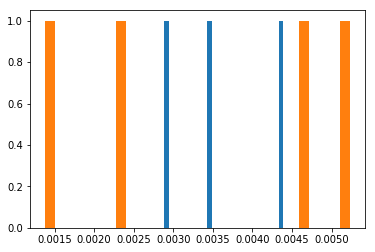

In [206]:
_ = train(rnn, ds, record=record, updater=updater(window=4), iterations=92, lr=0.00032)

In [169]:
record.yval.size()

torch.Size([2, 181848])

In [204]:
yt = y.t() > 0.999
collision = yt[1] & yt[1]
collision.sum()

tensor(35)

In [208]:
x, y = rnn.translate_index(ds, 0)
rnn.zero_grad()
with torch.no_grad():
    rnn.eval()
    hidden = rnn.init_hidden()
    output, hidden = rnn.forward_real(x, hidden)
    rnn.train()

In [211]:
def output_hotmap(output, index=None, data=None, ds=None, maxlen=None, cat=None):
    if index is not None:
        assert ds is not None
        data = ds.df.at[index, 'data']
    assert data is not None
    
    masks = [0x00ff00, 0xff0000] # green, red

    lo = output[1:]

    if len(data) != lo.size(0):
        print(f"Size mismatch: {len(data)} != {lo.size(0)}")
        return
    
    colors = []
    for i, y in enumerate(output[1:]):
        if cat is None:
            ci = 0
            if y[1] > y[0]:
                ci = 1
        else:
            ci = cat
        lvl = 1-y[ci]
        sclvl = int(255 * lvl)
        umlvl = sclvl * 0x010101
        mlvl = umlvl | masks[ci]
        #print("%d #%06x %f #%06x #%06x #%06x" % (ci, masks[ci], lvl, sclvl, umlvl, mlvl))
        color = "#%06x" % (mlvl)
        colors.append(color)
        
        if maxlen is not None and i == maxlen:
            break
    
    return color_all(data, colors)
        
def predict_and_display(model, ds, index, cat=None):
    x, y = rnn.translate_index(ds, index)
    rnn.zero_grad()
    with torch.no_grad():
        rnn.eval()
        hidden = rnn.init_hidden()
        output, hidden = rnn.forward_real(x, hidden)
        rnn.train()
    display(HTML("<pre>"+output_hotmap(output, ds=ds, index=index, cat=cat)))

In [218]:
#display(HTML(output_hotmap(torch.tensor([[0.02, 0.01], [0.2, 0.3], [0.4, 0.3], [0, 0]]), data="abc", maxlen=10)))
#display(HTML("<pre>"+output_hotmap(output, ds=ds, index=5)))
#display(HTML("<pre>"+output_hotmap(output/0.0065, ds=ds, index=5)))
#len(ds.df.at[5, 'ksb_good'])
predict_and_display(rnn, ds, 4)

In [210]:
s=output_hotmap(output, ds=ds, index=0, cat=0)

Size mismatch: 63293 != 182096
